In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [2]:
df = pd.read_csv("data_akbilgic.csv")

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_11416\105807154.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [4]:
df.head()

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,,
2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [5]:
df.drop(columns=['SP'], inplace=True, errors='ignore')

target_col = 'ISE'  # Target variable
feature_cols = [col for col in df.columns if col != target_col]  # All other features

In [6]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[feature_cols])
y_scaled = target_scaler.fit_transform(df[[target_col]])

In [7]:
sequence_length = 10  # 10-day lookback period
train_size = int(len(X_scaled) * 0.8)

# Split data
X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]

In [8]:
X_train, y_train = [], []
for i in range(len(X_train_data) - sequence_length):
    X_train.append(X_train_data[i:i + sequence_length])
    y_train.append(y_train_data[i + sequence_length])

X_test, y_test = [], []
for i in range(len(X_test_data) - sequence_length):
    X_test.append(X_test_data[i:i + sequence_length])
    y_test.append(y_test_data[i + sequence_length])


In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (418, 10, 7)
Testing data shape: (108, 10, 7)


In [10]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]), recurrent_dropout=0.1),
    LSTM(64, return_sequences=True, recurrent_dropout=0.1),
    LSTM(64, recurrent_dropout=0.1),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,545 (330.25 KB)

 Trainable params: 84,545 (330.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.1141 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0201 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0218 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0184 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0222 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0192 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0188 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0189 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0191 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 10/

In [12]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions
train_predictions = target_scaler.inverse_transform(train_predictions)
y_train_inv = target_scaler.inverse_transform(y_train)
test_predictions = target_scaler.inverse_transform(test_predictions)
y_test_inv = target_scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predictions))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predictions))
train_mae = mean_absolute_error(y_train_inv, train_predictions)
test_mae = mean_absolute_error(y_test_inv, test_predictions)
train_r2 = r2_score(y_train_inv, train_predictions)
test_r2 = r2_score(y_test_inv, test_predictions)
train_mape = np.mean(np.abs((y_train_inv - train_predictions) / (y_train_inv + 1e-5))) * 100
test_mape = np.mean(np.abs((y_test_inv - test_predictions) / (y_test_inv + 1e-5))) * 100

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


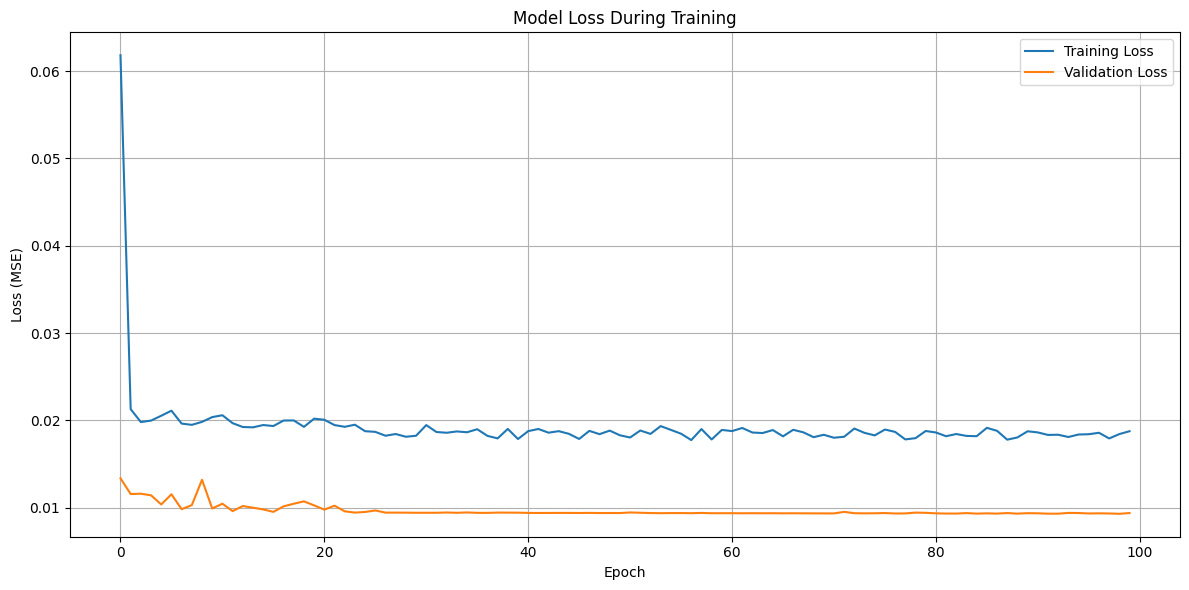

In [13]:
# Training Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()


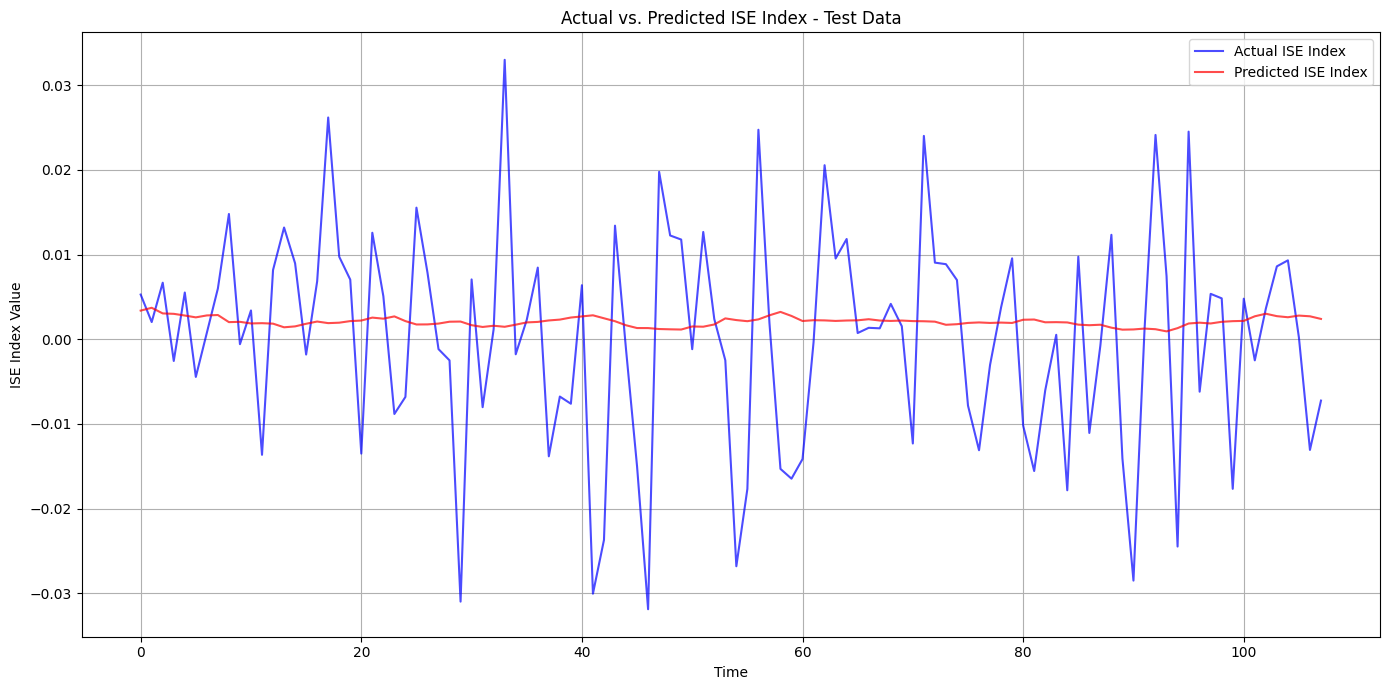

In [14]:
# Actual vs. Predicted Plot
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual ISE Index', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted ISE Index', color='red', alpha=0.7)
plt.title('Actual vs. Predicted ISE Index - Test Data')
plt.ylabel('ISE Index Value')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('test_predictions.png')
plt.show()

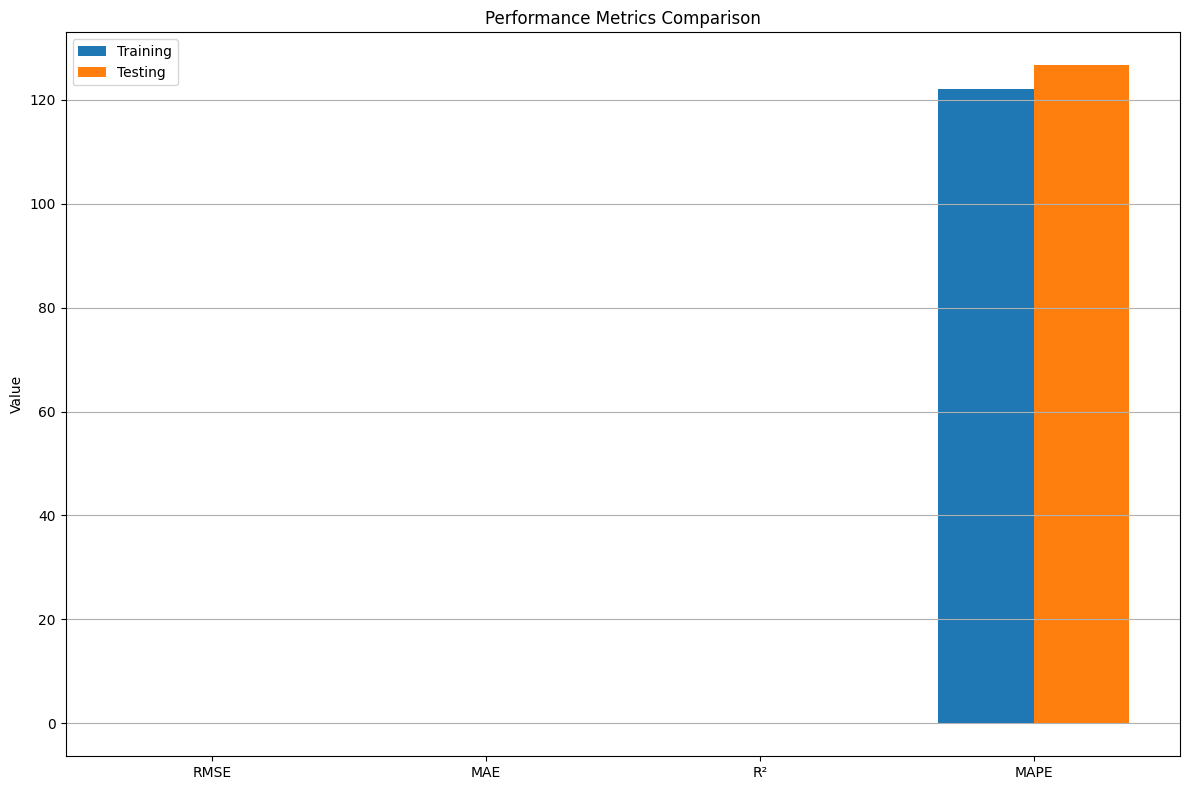

In [15]:
# Performance Metrics Bar Chart
metrics_names = ['RMSE', 'MAE', 'R²', 'MAPE']
train_values = [train_rmse, train_mae, train_r2, train_mape]
test_values = [test_rmse, test_mae, test_r2, test_mape]

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training')
plt.bar(x + width/2, test_values, width, label='Testing')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()